In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
from scipy.special import kn


In [66]:
g=20
c2 = 2*(np.pi**2)/45

# Load the data from CSV files
Gstar_df = pd.read_csv("Gstar.csv")
GstarS_df = pd.read_csv("GstarS.csv")

Gstar = dict(zip(Gstar_df.iloc[:, 0], Gstar_df.iloc[:, 1]))
GstarS = dict(zip(GstarS_df.iloc[:, 0], GstarS_df.iloc[:, 1]))

def g_star(Temp):
    # Find closest temperature value in Gstar
    closest_temp = min(Gstar.keys(), key=lambda t: abs(t - Temp))
    return Gstar[closest_temp]

def g_starS(Temp):
    # Find closest temperature value in GstarS
    closest_temp = min(GstarS.keys(), key=lambda t: abs(t - Temp))
    return GstarS[closest_temp]

# Define physical constants
M_Pl = 1.22e19  # Planck mass in GeV

# Particle properties
particle_mass = {
    'TestBaryon': 1e4, #1TeV
    'TestMeson': 1 #1GeV
}

particle_coupling_constants = {
    'StrangenessConserving': 8.5
}

particle_cross_sections = {
    'TestMeson': 1e-3,
    }

particle_ratios = {
    particle: particle_mass[particle] / particle_mass["TestBaryon"]
    for particle in particle_mass
}

def n_eq(x, particle):
    mass = particle_mass.get(particle, 1)
    T = mass/x
    return (g/(2*(np.pi**2)))*(mass**2)*(T)*kn(2, x)

# Define s(x, m) function (entropy density)
def s(x, particle):
    mass = particle_mass.get(particle, 1)
    g_starS_vec = np.vectorize(g_starS) 
    return c2 * g_starS_vec(mass / x) * (mass / x)**3

def Y_EQ(x, particle):
    mass = particle_mass.get(particle, 1)
    return n_eq(x, particle) / s(x, particle)

# Function to compute prefactor k
def fk(particle):
    mass = particle_mass.get(particle, 1)
    cross_section = particle_cross_sections.get(particle, 1)
    return np.sqrt(np.pi * M_Pl**2 / 45) * mass * cross_section

# Function to compute variables in the Boltzmann equation
def Variables(x, particle):
    mass = particle_mass.get(particle, 1)
    T = mass / x
    return k * g_star(T) / x**2  # g_star(T) is assumed to be defined elsewhere

# Boltzmann equation in log space
def dYdx_log(x, logY, particle):
    Y = np.exp(logY)
    ratio = particle_ratios.get(particle, 1)
    x_ratio = max(0.01, x * ratio)
    #x_ratio = x * ratio
    return -((Y**2 - Y_EQ(x_ratio, particle)**2) * Variables(x_ratio, particle)) / Y # d(logY)/dx

In [68]:
def thermally_averaged_cross_section(x,particle):
    c_chi = particle_coupling_constants.get("StrangenessConserving")
    m_chi = particle_mass.get(particle,1)
    f_a = particle_mass.get("TestBaryon")
    T = m_chi/x
    return ((c_chi**4) * (m_chi) * T) / (64*np.pi*(f_a**4))


# Function to compute prefactor k
def fkdynamic(x,particle):
    mass = particle_mass.get(particle, 1)
    cross_section = thermally_averaged_cross_section(x,particle)
    return np.sqrt(np.pi * M_Pl**2 / 45) * mass * cross_section

# Function to compute variables in the Boltzmann equation
def Variablesdynamic(x, particle):
    mass = particle_mass.get(particle, 1)
    T = mass / x
    k = fkdynamic(x,particle)
    return k * g_star(T) / x**2  # g_star(T) is assumed to be defined elsewhere


def dYdx_logdynamic(x, logY, particle):
    Y = np.exp(logY)
    ratio = particle_ratios.get(particle, 1)
    x_ratio = max(0.01, x * ratio)
    return -((Y**2 - Y_EQ(x_ratio, particle)**2) * Variablesdynamic(x_ratio, particle)) / Y # d(logY)/dx

C:\Users\press\AppData\Local\Temp\ipykernel_19504\1694393433.py:72: RuntimeWarning: overflow encountered in exp
  Y = np.exp(logY)
C:\Users\press\AppData\Local\Temp\ipykernel_19504\1694393433.py:76: RuntimeWarning: invalid value encountered in divide
  return -((Y**2 - Y_EQ(x_ratio, particle)**2) * Variables(x_ratio, particle)) / Y # d(logY)/dx
C:\Users\press\AppData\Local\Temp\ipykernel_19504\1694393433.py:76: RuntimeWarning: overflow encountered in square
  return -((Y**2 - Y_EQ(x_ratio, particle)**2) * Variables(x_ratio, particle)) / Y # d(logY)/dx


Frozen-out value of TestMeson with sigma = 0.001, and mass = 1 GeV is 9.503775822699148e-20
Frozen-out value of TestBaryon with sigma = 1, and mass = 10000.0 GeV is 2.5207876293111388e-15
Σm_i*Y_i = 2.5207876388149146e-11 GeV


Text(0.05, 0.001, '$\\Sigma m_iY_i$ = 2.52e-11 GeV')

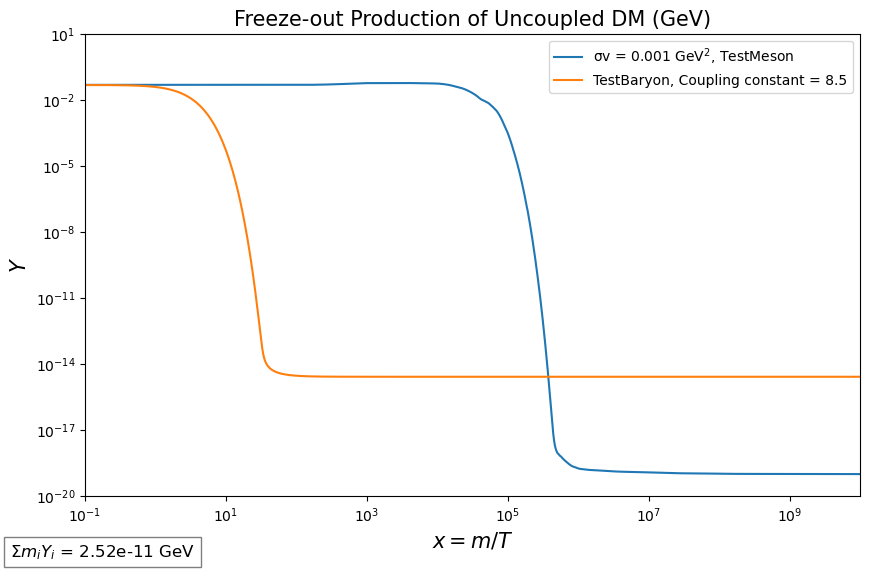

In [78]:
# Integration setup
particlesBaryon = ["TestBaryon"]
particlesMeson = ["TestMeson"]

x_min, x_max = 1e-2, 1E10
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
#xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particlesMeson:
    cross_section = particle_cross_sections.get(particle, 1)
    mass = particle_mass.get(particle, 1)
    
    k = fk(particle)

    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_log(x, logY, particle),
        (x_min, x_max),
        [np.log(Y_EQ(x_min, particle))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=5e-2,
        atol=5e-2
    )

    # Convert back from log space
    Y_values = np.exp(sol.y[0])

    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_values[-1]}')

    plt.loglog(sol.t, Y_values, label=f'σv = {cross_section} GeV$^{2}$, {particle}')

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

for particle in particlesBaryon:
    cross_section = particle_cross_sections.get(particle, 1)
    mass = particle_mass.get(particle, 1)
    
    #k = fkpractice(x,particle)

    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_logdynamic(x, logY, particle),
        (x_min, x_max),
        [np.log(np.array(Y_EQ(x_min, particle)))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-10,
        atol=1e-10,
        jac = None
    )

    #print(sol.y)
    # Convert back from log space
    Y_values = np.exp(sol.y[0])

    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_values[-1]}')

    plt.loglog(sol.t, Y_values, label=f'{particle}, Coupling constant = {particle_coupling_constants.get("StrangenessConserving")}')

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')


plt.ylim(1E-20,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out Production of Uncoupled DM (GeV)', size= 15)
plt.legend()
plt.gcf().text(0.05, 0.001, rf"$\Sigma m_iY_i$ = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.show()
#plt.savefig('TestFreezeOut.png', facecolor = 'w')